# Studi Kasus dan Analisis Masalah
___

Studi kasus yang digunakan adalah Binary Knapsack. Binary Knapsack merupakan masalah kombinatorial yang bertujuan memaksimalkan profit dari knapsack (karung) tanpa melebihi kapasitas maksimalnya. 

Pada kasus ini, digunakan data dengan jumlah barang sebanyak 23 item (dapat berubah sesuai dengan data yang di-_load_), yang masing-masingnya memiliki `price` dan `weight` yang berbeda. Data didapatkan dari dataset pada link berikut: http://artemisa.unicauca.edu.co/~johnyortega/instances_01_KP/.

 Dari studi kasus diatas, akan dipilih barang dengan `weight` tidak lebih dari 10.000 (kg) dengan memaksimalkan _cost_ (dalam hal ini `price`) yang didapat. 

# Metode dan Desain Individu
___

Dalam Tugas 3 kali ini, masalah diselesaikan menggunakan Bat Algorithm (BA). Dalam Bat Algorithm, satu individu merepresentasikan satu solusi. Representasi individu yang kita gunakan adalah sebagai berikut:

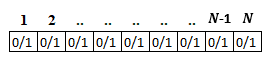

yang mana 1 berarti item akan dimasukkan ke dalam knapsack, sedangkan 0 berarti sebaliknya.

Pada dasarnya, BA didesain untuk menyelesaikan permasalahan kontinu, sehingga diperlukan diskritisasi dalam menyelesaikan permasalahan knapsack. Individu dikodekan sebagai bilangan riil dalam interval [0,1]. Lalu dilakukan diskritisasi vektor bernilai riil tersebut menjadi vektor bernilai biner menggunakan _Great Value Priority_

Fungsi fitness yang digunakan dalam kasus ini didefinisikan berupa $fit = T$ , di mana $T$ adalah total nilai `price` dari barang yang terpilih.


# Code
___

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

In [2]:
import data_module as dm
DLS_X, DLS_Y, DLS_W, DLD_X, DLD_Y, DLD_W = dm.import_data()
#DLS = data large scale, terdiri dari ratusan datapoints
#DLD = data low dimension, jumlah datapoints kurang dari 100 data

In [3]:
#select DLD first, as we gonna try to build up the model (faster execution)
data_w = DLD_W[0] #maximum weight
data_x = DLD_X[0] #datapoints
data_y = DLD_Y[0] #optimum values

## Representasi Solusi
Solusi direpresentasikan sebagai boolean mask (0/1) sepanjang $N$, dimana $N$ adalah ukuran data. 1 atau True berarti bahwa data tersebut terpilih untuk dimasukkan ke dalam knapsack. Sebaliknya, 0 atau False berarti data tersebut tidak terpilih/ tidak dimasukkan ke dalam knapsack

In [4]:
sol = np.random.random(len(data_x))
sol

array([0.64783482, 0.98476375, 0.86672694, 0.23760339, 0.79759453,
       0.51813009, 0.00636131, 0.4569418 , 0.74476493, 0.56555868,
       0.43837508, 0.03528769, 0.21511951, 0.69583565, 0.95854513,
       0.30275972, 0.82743162, 0.96287689, 0.21304842, 0.55318294])

In [5]:
#after discretizatoin
np.round(sol).astype(bool)

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False,  True])

In [6]:
idx = np.arange(len(data_x))
idx = idx[np.round(sol).astype(bool)]
carried = data_x.iloc[idx]
carried

,weight,price
1,91,84
2,72,83
3,90,43
5,55,44
6,8,6
9,61,25
10,15,83
14,75,14
15,29,48
17,17,96


## Fitness Function

In [7]:
def fit(sol, data, max_w) :
    #Discretization
    mask = np.round(sol).astype(bool)
    
    #decode
    idx = np.arange(len(data))
    idx = idx[mask]
    data_solution = data.iloc[idx]
    
    #price 
    price = np.sum(data_solution['price'])
    weight = np.sum(data_solution['weight'])
    if weight <= max_w:
        return price
    else :
        return 0

## Bat Class

In [8]:
class bat:
    def __init__(self, population, data, max_w, fmin, fmax, A, alpha, gamma):
        self.population = population
        self.data = data
        self.max_w = max_w
        self.fmin = fmin
        self.fmax = fmax
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.data_size = len(data)
        self.best_sol = None
        self.t = 1 #iteration 
        
        self.init_x()
        self.init_f()
        self.init_v()
        self.init_y()
        self.init_r()
                
    def init_x (self):
        self.solutions =  np.random.random((self.population,self.data_size))
        
    def init_f (self):
        self.f = np.random.uniform(self.fmin,self.fmax,self.population)

    def init_v (self):
        self.v = np.zeros((self.population, self.data_size))

    def init_y (self):
        Y = np.zeros(len(self.solutions))
        for i,sol in enumerate(self.solutions) : 
            Y[i] = fit(sol,self.data, self.max_w)
        
        self.Y = Y

    def init_r (self):
        self.r = np.random.random(self.population)
        self.r0 = self.r
        
    
    def update_f(self):
        self.fmin = np.min(self.f)
        self.fmax = np.max(self.f)
        betha = np.random.random(len(self.f))
        self.f = betha*(self.fmax-self.fmin) + self.fmin
    
    def update_v(self):
        self.find_best_solution()
        r = (self.solutions - self.best_sol)
        rr = [r[i] * self.f[i] for i in range(len(r))] # perkalian r dengan f
        
        self.v = self.v + rr
        self.normalize_v()
    
    def update_x(self):
        self.solutions += self.v
        self.normalize_solution()
        self.update_y()
        self.localsearch()
        self.update_y
        self.find_best_solution()
        
    def update_A(self):
        self.A = self.A * self.alpha
    
    def update_r(self):
        self.r = self.r0 * (1- np.exp(-self.gamma*self.t))
        self.t += 1
    
    def update_y(self):
        Y = np.zeros(len(self.solutions))
        for i,sol in enumerate(self.solutions) : 
            Y[i] = fit(sol,self.data, self.max_w)
        self.Y = Y

    #__________________
    def find_best_solution(self):
        self.best_sol = self.solutions[np.argmax(self.Y)]
        
    def normalize_solution(self):
#         self.solutions = np.absolute(self.solutions / (np.max(self.solutions) - np.min(self.solutions)))
        self.solutions[self.solutions > 1] = 1
        self.solutions[self.solutions < 0] = 0
        
    def normalize_v(self):
        self.v = np.sin(self.v)
            
    def extract_solution(self):
        #Discretization
        mask = np.round(self.best_sol).astype(bool)

        #decode
        idx = np.arange(len(self.data))
        idx = idx[mask]
        data_solution = self.data.iloc[idx]

        return data_solution
        
    def mutate(self,x):
        size = len(x)
        sizex = size//5
        idx = np.random.permutation(size)[:sizex]

        x[idx] = 1-x[idx]

        return x
    
    def localsearch(self):
        idxm = np.where(self.Y == 0)
        cm = self.solutions[ idxm ]
        for i in range(len(cm)): 
            cm[i] = self.mutate(cm[i])
        
        self.solutions[idxm] = cm
        


## Bat Algorithm

In [9]:
# Hyper parameters 
fmin = 0
fmax = 1
A = 1
alpha = 0.98
gamma = 0.98
population = 75
epoch = 25

In [10]:
#select DLD first, as we gonna try to build up the model (faster execution)
data_w = DLS_W[4] #maximum weight
data_x = DLS_X[4] #datapoints
data_y = DLS_Y[4] #optimum values

data_w = DLD_W[8] #maximum weight
data_x = DLD_X[8] #datapoints
data_y = DLD_Y[8] #optimum values

# data_w = 1000000

In [26]:
solution = []
acc = []
bat_haviour = []
for loop in range(30):
    localSolution = []
    baat = bat(population,data_x,data_w,fmin,fmax,A,alpha,gamma)
    for i in range(epoch):
        baat.update_f()
        baat.update_v()
        baat.update_x()    
        baat.update_r()
        localSolution.append(np.max(baat.Y))
#         if (i==epoch-1):
    bat_haviour.append(np.average(baat.Y))
    solution.append(sum(localSolution)/len(localSolution))
    acc.append((sum(localSolution)/len(localSolution))/data_y)
    

Average accuracy equal to 99.699  %
with an average solution equal to 9737.597  from  9767


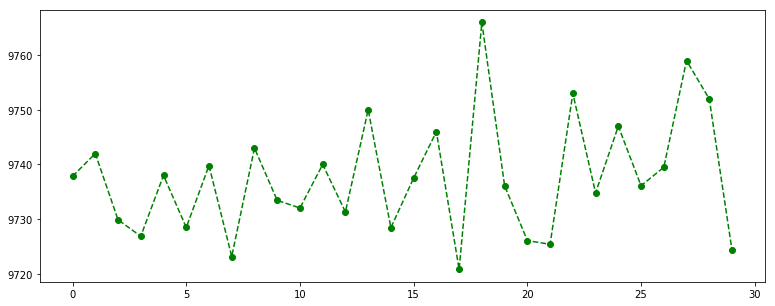

In [27]:
averageSolution = sum(solution)/len(solution)
plt.figure(figsize=(13,5))
plt.plot(solution, "go--")
averageAcc = (sum(acc)/len(solution))*100
print ("Average accuracy equal to",'%.3f' % averageAcc, ' %')
print ("with an average solution equal to",'%.3f' % averageSolution, " from ", data_y)
plt.show()

with an average behaviour of bat colony equal to 8029.891


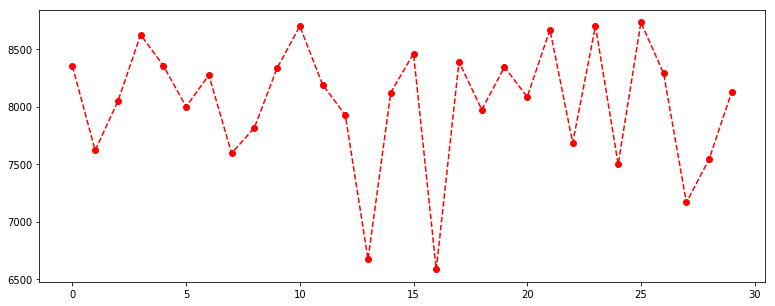

In [28]:
plt.figure(figsize=(13,5))
plt.plot(bat_haviour, "ro--")
print ("with an average behaviour of bat colony equal to",'%.3f' % np.average(bat_haviour))